# Data Loading

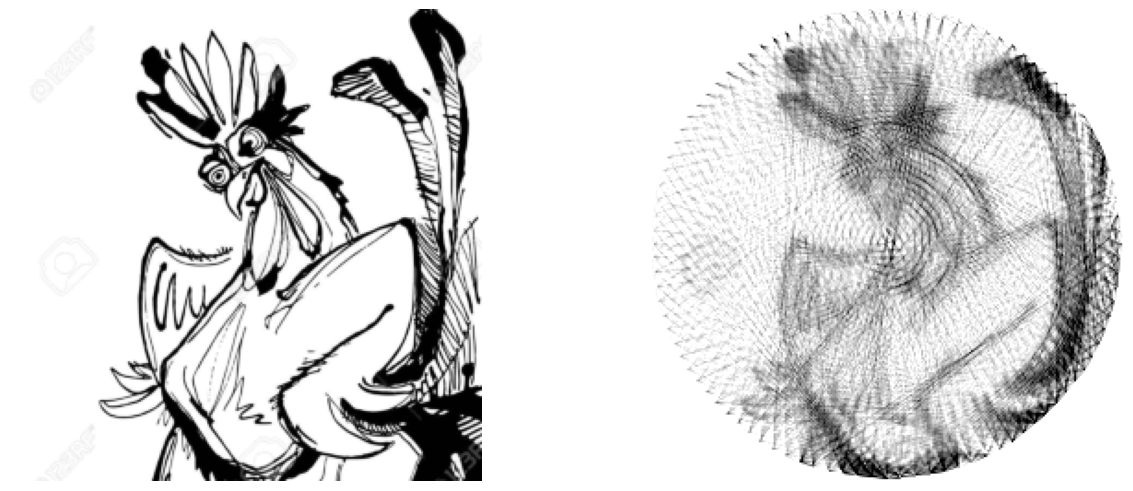

In [1]:
import os

import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from skimage.io import imread
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.functional import to_tensor
from typing import Tuple


class Config:
    DATASET_DIR = "/kaggle/input/stringart-ai-1000/stringart-dataset"
    UNET_PLOT_DIR= "/kaggle/working"
    

class StringArtDataset(Dataset):
    def __init__(self, file_list):
        self.file_list = file_list

        self.images = []
        self.labels = []

        for img_path, label_path in self.file_list:
            img = np.array(imread(img_path))
            label = np.array(imread(label_path))

            self.images.append(to_tensor(img))
            self.labels.append(to_tensor(label))

        self.images = torch.stack(self.images)
        self.labels = torch.stack(self.labels)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


def load_data(input_dir: str, batch_size: int = 64) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """Load the dataset from the specified directory, split it into training, validation, and test sets,
    and return corresponding DataLoaders for each set.

    Parameters
    ----------
    input_dir : str
        The directory path containing the dataset. It should have a `metadata.csv` file and
        subdirectories `images` and `labels` containing the image and label files, respectively.
    batch_size : int, optional
        The batch size for the DataLoader. Default is 64.

    Returns
    -------
    tuple
        A tuple containing three `DataLoader` objects:
        - train_loader (DataLoader): The DataLoader for the training dataset.
        - validation_loader (DataLoader): The DataLoader for the validation dataset.
        - test_loader (DataLoader): The DataLoader for the test dataset.
    """

    df = pd.read_csv(os.path.join(input_dir, "metadata.csv"))
    samples = [
        (os.path.join(input_dir, "images", img_name), os.path.join(input_dir, "labels", label_name))
        for _, (img_name, label_name) in df.iterrows()
    ]

    train_data, temp_data = train_test_split(samples, test_size=0.3, random_state=42)
    validation_data, test_data = train_test_split(temp_data, test_size=0.1, random_state=42)

    train_loader = DataLoader(StringArtDataset(train_data), batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(StringArtDataset(validation_data), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(StringArtDataset(test_data), batch_size=batch_size, shuffle=False)

    return train_loader, validation_loader, test_loader



train_loader, validation_loader, test_loader = load_data(Config.DATASET_DIR, batch_size=16)

batch = next(iter(train_loader))
img, label = batch[0][0], batch[1][0]

image = img.cpu().numpy().transpose(1, 2, 0)
label = label.cpu().numpy().transpose(1, 2, 0)

fig, axs = plt.subplots(1, 2, figsize=[2 * 6.4, 4.8], constrained_layout=True)
cmap = "gray"

axs[0].imshow(image, cmap=cmap)
axs[0].set_axis_off()

axs[1].imshow(label, cmap=cmap)
axs[1].set_axis_off()

fig.show()


In [2]:
import torch
from torch import nn, optim

class DoubleConv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv2d, self).__init__()

        self.double_conv2d = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.double_conv2d(x)


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        self.encoder = nn.ModuleList(
            [
                DoubleConv2d(in_channels, 16),
                DoubleConv2d(16, 32),
                DoubleConv2d(32, 64),
                DoubleConv2d(64, 128),
                DoubleConv2d(128, 256),
            ]
        )

        self.decoder = nn.ModuleList(
            [
                DoubleConv2d(256, 128),
                DoubleConv2d(128, 64),
                DoubleConv2d(64, 32),
                DoubleConv2d(32, 16),
            ]
        )

        self.deconv = nn.ModuleList(
            [
                nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
                nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
                nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
                nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            ]
        )

        self.pool = nn.MaxPool2d((2, 2))
        self.last_layer_conv = nn.Conv2d(in_channels=16, out_channels=out_channels, kernel_size=1, stride=1)

    def forward(self, x):
        stk = []
        for encoder in self.encoder:
            x = encoder(x)
            stk.append(x)
            x = self.pool(x)

        x = stk.pop(-1)
        for index in range(len(self.decoder)):
            encoder_output = stk.pop(-1)
            x = self.deconv[index](x)

            x = torch.cat([encoder_output, x], dim=1)
            x = self.decoder[index](x)

        return torch.sigmoid(self.last_layer_conv(x))

# Training Functions

In [3]:
import os
import torch


class EarlyStopping:
    def __init__(self, patience=20, verbose=False, delta=0):
        """
        Args:
            patience (int): How many epochs to wait after last improvement.
            verbose (bool): Print messages when early stopping is triggered.
            delta (float): Minimum change in monitored value to qualify as improvement.
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


class ModelCheckpoint:
    def __init__(self, save_dir="checkpoints", monitor="val_loss", mode="min", verbose=True):
        """
        Args:
            save_dir (str): Path to save models.
            monitor (str): Metric to monitor ('val_loss').
            mode (str): 'min' means lower is better, 'max' means higher is better.
            verbose (bool): Whether to print messages.
        """
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)

        self.monitor = monitor
        self.mode = mode
        self.verbose = verbose

        if self.mode == "min":
            self.best_score = float("inf")
        else:
            self.best_score = -float("inf")

        self.best_model_data = None
        self.best_epoch = None

    def update(
        self,
        epoch,
        model,
        optimizer,
        scheduler,
        current_score,
    ):
        """
        Update internal best model state if current score is better.
        """

        is_best = False

        if (self.mode == "min" and current_score < self.best_score) or (
            self.mode == "max" and current_score > self.best_score
        ):
            self.best_score = current_score
            self.best_epoch = epoch
            is_best = True

        if is_best:
            self.best_model_data = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict(),
                self.monitor: current_score,
            }

            if self.verbose:
                print(f"[ModelCheckpoint] Updated best model at epoch {epoch} with {self.monitor}: {current_score:.4f}")

    def save(self, filename="gan_checkpoint.pth"):
        """
        Save the best model data to disk.
        """

        if self.best_model_data is None:
            print("[ModelCheckpoint] No model to save yet.")
            return

        save_path = os.path.join(self.save_dir, filename)
        torch.save(self.best_model_data, save_path)

        if self.verbose:
            print(f"[ModelCheckpoint] Saved best model to '{save_path}' (epoch {self.best_epoch}).")


In [4]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import os


def train(
    model,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    accumulation_steps: int = 4,
    device: torch.device = None,
    scheduler = None,
    early_stopping: EarlyStopping | None = None,
    model_checkpoint: ModelCheckpoint | None = None,
):
    """Train a PyTorch model and validate it after each epoch.

    Parameters
    ----------
    model : torch.nn.Module
        The model to be trained.
    train_loader : torch.utils.data.DataLoader
        DataLoader for the training dataset.
    val_loader : torch.utils.data.DataLoader
        DataLoader for the validation dataset.
    criterion : torch.nn.Module
        The loss function to be used during training.
    optimizer : torch.optim.Optimizer
        The optimizer to update the model's parameters.
    epochs : int
        The number of epochs for training.
    accumulation_steps : int, optional
        Number of gradient accumulation steps before performing an optimizer step. Default is 4.
    device : torch.device, optional
        The device on which to run the model (CPU or CUDA). If None, the function will automatically choose the device.
    scheduler : torch.optim.lr_scheduler optional
        Learning rate scheduler to adjust the learning rate after each epoch.
    early_stopping: EarlyStopping, optional
        Early Stopping method.
    model_checkpoint: ModelCheckpoint, optional
        Model Checkpoint save logic.

    Returns
    -------
    tuple
        A tuple containing two lists:
            - train_loss_history (list): List of training loss values at each epoch.
            - val_loss_history (list): List of validation loss values at each epoch.
    """

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)

    train_loss_history = []
    val_loss_history = []

    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")
        print("-" * 30)

        # training phase
        model.train()
        running_train_loss = 0.0

        for index, (inputs, labels) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()

            if (index + 1) % accumulation_steps == 0 or (index + 1) == len(train_loader):
                optimizer.step()
                optimizer.zero_grad()

            running_train_loss += loss.item()

        epoch_train_loss = running_train_loss / len(train_loader)
        train_loss_history.append(epoch_train_loss)

        # validation Phase
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)

                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_loss_history.append(epoch_val_loss)

        print(f"Train Loss: {epoch_train_loss:.4f}", end=" | ")
        print(f"Val   Loss: {epoch_val_loss:.4f}")

        current_lr = optimizer.param_groups[0]["lr"]
        print(f"Learning Rate: {current_lr:.8f}")

        if scheduler:
            scheduler.step(epoch_val_loss)

        if model_checkpoint is not None:
            model_checkpoint.update(
                epoch,
                model,
                optimizer,
                scheduler,
                current_score=epoch_val_loss
            )

        if early_stopping is not None:
            early_stopping(epoch_val_loss)
            
            if early_stopping.early_stop:
                print("Early stopping triggered. Stopping training.")
                break

    return train_loss_history, val_loss_history


def plot_loss(train_loss, val_loss, path: str | None = None, name: str | None = None):
    """Plot the training and validation loss over epochs.

    Parameters
    ----------
    train_loss : list
        List of training loss values for each epoch.
    val_loss : list
        List of validation loss values for each epoch.
    path: str | None
        Directory path where to save output. Default is None, meaning output will not be saved.
    name: str | None
        File name of the saved output.

    Returns
    -------
    None
        This function does not return any value. It directly displays the plot.
    """

    plt.title("Training & Validation Loss")
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Val Loss")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.legend()
    plt.grid(True)

    if path is not None:
        name = name if name is not None else "loss.png"
        plt.savefig(os.path.join(path, name))
    plt.show()


def plot_test_results(model, test_loader, device, num_images=5, path: str | None = None, name: str | None = None):
    """Plot a set of test results, displaying input images, predicted outputs, and ground truth labels.

    Parameters
    ----------
    model : torch.nn.Module
       The trained model used to generate predictions.
    test_loader : torch.utils.data.DataLoader
       DataLoader for the test dataset.
    device : torch.device
       The device on which the model is running (CPU or CUDA).
    num_images : int, optional
       The number of images to display. Default is 5.
    path: str | None
        Directory path where to save output. Default is None, meaning output will not be saved.
    name: str | None
        File name of the saved output.

    Returns
    -------
    None
       This function does not return any value. It directly displays the plot.
    """

    model.eval()

    with torch.no_grad():
        # get first batch
        sample_inputs, sample_labels = next(iter(test_loader))
        sample_inputs, sample_labels = sample_inputs.to(device), sample_labels.to(device)

        # get model outputs
        sample_outputs = model(sample_inputs)

        # number of images to display
        batch_size = sample_inputs.size(0)
        num_images = min(num_images, batch_size)

        fig, axes = plt.subplots(num_images, 3, figsize=(12, 4 * num_images))
        for i in range(num_images):
            # input
            axes[i, 0].imshow(sample_inputs[i].cpu().squeeze(0), cmap="gray")
            axes[i, 0].set_title(f"Input Image {i + 1}")
            axes[i, 0].axis("off")

            # predicted
            axes[i, 1].imshow(sample_outputs[i].cpu().squeeze(0), cmap="gray")
            axes[i, 1].set_title(f"Predicted Image {i + 1}")
            axes[i, 1].axis("off")

            # ground truth
            axes[i, 2].imshow(sample_labels[i].cpu().squeeze(0), cmap="gray")
            axes[i, 2].set_title(f"Ground Truth {i + 1}")
            axes[i, 2].axis("off")

        plt.tight_layout()

        if path is not None:
            name = name if name is not None else "predictions.png"
            plt.savefig(os.path.join(path, name))
        plt.show()

# Training


Epoch 1/1000
------------------------------


Train Loss: 0.8163 | Val   Loss: 0.7841
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 1 with val_loss: 0.7841

Epoch 2/1000
------------------------------


Train Loss: 0.7777 | Val   Loss: 0.7602
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 2 with val_loss: 0.7602

Epoch 3/1000
------------------------------


Train Loss: 0.7489 | Val   Loss: 0.7401
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 3 with val_loss: 0.7401

Epoch 4/1000
------------------------------


Train Loss: 0.7316 | Val   Loss: 0.7242
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 4 with val_loss: 0.7242

Epoch 5/1000
------------------------------


Train Loss: 0.7178 | Val   Loss: 0.7143
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 5 with val_loss: 0.7143

Epoch 6/1000
------------------------------


Train Loss: 0.7097 | Val   Loss: 0.7080
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 6 with val_loss: 0.7080

Epoch 7/1000
------------------------------


Train Loss: 0.7040 | Val   Loss: 0.7035
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 7 with val_loss: 0.7035

Epoch 8/1000
------------------------------


Train Loss: 0.7005 | Val   Loss: 0.6998
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 8 with val_loss: 0.6998

Epoch 9/1000
------------------------------


Train Loss: 0.6967 | Val   Loss: 0.6970
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 9 with val_loss: 0.6970

Epoch 10/1000
------------------------------


Train Loss: 0.6936 | Val   Loss: 0.6937
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 10 with val_loss: 0.6937

Epoch 11/1000
------------------------------


Train Loss: 0.6903 | Val   Loss: 0.6912
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 11 with val_loss: 0.6912

Epoch 12/1000
------------------------------


Train Loss: 0.6867 | Val   Loss: 0.6877
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 12 with val_loss: 0.6877

Epoch 13/1000
------------------------------


Train Loss: 0.6839 | Val   Loss: 0.6849
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 13 with val_loss: 0.6849

Epoch 14/1000
------------------------------


Train Loss: 0.6807 | Val   Loss: 0.6807
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 14 with val_loss: 0.6807

Epoch 15/1000
------------------------------


Train Loss: 0.6782 | Val   Loss: 0.6799
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 15 with val_loss: 0.6799

Epoch 16/1000
------------------------------


Train Loss: 0.6757 | Val   Loss: 0.6774
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 16 with val_loss: 0.6774

Epoch 17/1000
------------------------------


Train Loss: 0.6732 | Val   Loss: 0.6767
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 17 with val_loss: 0.6767

Epoch 18/1000
------------------------------


Train Loss: 0.6712 | Val   Loss: 0.6745
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 18 with val_loss: 0.6745

Epoch 19/1000
------------------------------


Train Loss: 0.6687 | Val   Loss: 0.6694
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 19 with val_loss: 0.6694

Epoch 20/1000
------------------------------


Train Loss: 0.6659 | Val   Loss: 0.6673
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 20 with val_loss: 0.6673

Epoch 21/1000
------------------------------


Train Loss: 0.6635 | Val   Loss: 0.6658
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 21 with val_loss: 0.6658

Epoch 22/1000
------------------------------


Train Loss: 0.6624 | Val   Loss: 0.6638
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 22 with val_loss: 0.6638

Epoch 23/1000
------------------------------


Train Loss: 0.6591 | Val   Loss: 0.6604
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 23 with val_loss: 0.6604

Epoch 24/1000
------------------------------


Train Loss: 0.6557 | Val   Loss: 0.6562
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 24 with val_loss: 0.6562

Epoch 25/1000
------------------------------


Train Loss: 0.6529 | Val   Loss: 0.6539
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 25 with val_loss: 0.6539

Epoch 26/1000
------------------------------


Train Loss: 0.6503 | Val   Loss: 0.6528
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 26 with val_loss: 0.6528

Epoch 27/1000
------------------------------


Train Loss: 0.6465 | Val   Loss: 0.6489
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 27 with val_loss: 0.6489

Epoch 28/1000
------------------------------


Train Loss: 0.6438 | Val   Loss: 0.6434
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 28 with val_loss: 0.6434

Epoch 29/1000
------------------------------


Train Loss: 0.6402 | Val   Loss: 0.6394
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 29 with val_loss: 0.6394

Epoch 30/1000
------------------------------


Train Loss: 0.6364 | Val   Loss: 0.6370
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 30 with val_loss: 0.6370

Epoch 31/1000
------------------------------


Train Loss: 0.6327 | Val   Loss: 0.6353
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 31 with val_loss: 0.6353

Epoch 32/1000
------------------------------


Train Loss: 0.6309 | Val   Loss: 0.6257
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 32 with val_loss: 0.6257

Epoch 33/1000
------------------------------


Train Loss: 0.6242 | Val   Loss: 0.6248
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 33 with val_loss: 0.6248

Epoch 34/1000
------------------------------


Train Loss: 0.6199 | Val   Loss: 0.6171
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 34 with val_loss: 0.6171

Epoch 35/1000
------------------------------


Train Loss: 0.6165 | Val   Loss: 0.6168
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 35 with val_loss: 0.6168

Epoch 36/1000
------------------------------


Train Loss: 0.6125 | Val   Loss: 0.6097
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 36 with val_loss: 0.6097

Epoch 37/1000
------------------------------


Train Loss: 0.6076 | Val   Loss: 0.6083
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 37 with val_loss: 0.6083

Epoch 38/1000
------------------------------


Train Loss: 0.6061 | Val   Loss: 0.6066
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 38 with val_loss: 0.6066

Epoch 39/1000
------------------------------


Train Loss: 0.6043 | Val   Loss: 0.6014
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 39 with val_loss: 0.6014

Epoch 40/1000
------------------------------


Train Loss: 0.6002 | Val   Loss: 0.5985
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 40 with val_loss: 0.5985

Epoch 41/1000
------------------------------


Train Loss: 0.5978 | Val   Loss: 0.5963
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 41 with val_loss: 0.5963

Epoch 42/1000
------------------------------


Train Loss: 0.5959 | Val   Loss: 0.5918
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 42 with val_loss: 0.5918

Epoch 43/1000
------------------------------


Train Loss: 0.5924 | Val   Loss: 0.5920
Learning Rate: 0.00010000
EarlyStopping counter: 1/20

Epoch 44/1000
------------------------------


Train Loss: 0.5909 | Val   Loss: 0.5916
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 44 with val_loss: 0.5916

Epoch 45/1000
------------------------------


Train Loss: 0.5891 | Val   Loss: 0.5897
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 45 with val_loss: 0.5897

Epoch 46/1000
------------------------------


Train Loss: 0.5872 | Val   Loss: 0.5849
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 46 with val_loss: 0.5849

Epoch 47/1000
------------------------------


Train Loss: 0.5859 | Val   Loss: 0.5899
Learning Rate: 0.00010000
EarlyStopping counter: 1/20

Epoch 48/1000
------------------------------


Train Loss: 0.5861 | Val   Loss: 0.5851
Learning Rate: 0.00010000
EarlyStopping counter: 2/20

Epoch 49/1000
------------------------------


Train Loss: 0.5848 | Val   Loss: 0.5818
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 49 with val_loss: 0.5818

Epoch 50/1000
------------------------------


Train Loss: 0.5823 | Val   Loss: 0.5805
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 50 with val_loss: 0.5805

Epoch 51/1000
------------------------------


Train Loss: 0.5809 | Val   Loss: 0.5790
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 51 with val_loss: 0.5790

Epoch 52/1000
------------------------------


Train Loss: 0.5792 | Val   Loss: 0.5810
Learning Rate: 0.00010000
EarlyStopping counter: 1/20

Epoch 53/1000
------------------------------


Train Loss: 0.5786 | Val   Loss: 0.5775
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 53 with val_loss: 0.5775

Epoch 54/1000
------------------------------


Train Loss: 0.5779 | Val   Loss: 0.5760
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 54 with val_loss: 0.5760

Epoch 55/1000
------------------------------


Train Loss: 0.5770 | Val   Loss: 0.5776
Learning Rate: 0.00010000
EarlyStopping counter: 1/20

Epoch 56/1000
------------------------------


Train Loss: 0.5764 | Val   Loss: 0.5764
Learning Rate: 0.00010000
EarlyStopping counter: 2/20

Epoch 57/1000
------------------------------


Train Loss: 0.5750 | Val   Loss: 0.5749
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 57 with val_loss: 0.5749

Epoch 58/1000
------------------------------


Train Loss: 0.5742 | Val   Loss: 0.5741
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 58 with val_loss: 0.5741

Epoch 59/1000
------------------------------


Train Loss: 0.5728 | Val   Loss: 0.5737
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 59 with val_loss: 0.5737

Epoch 60/1000
------------------------------


Train Loss: 0.5718 | Val   Loss: 0.5716
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 60 with val_loss: 0.5716

Epoch 61/1000
------------------------------


Train Loss: 0.5715 | Val   Loss: 0.5741
Learning Rate: 0.00010000
EarlyStopping counter: 1/20

Epoch 62/1000
------------------------------


Train Loss: 0.5729 | Val   Loss: 0.5745
Learning Rate: 0.00010000
EarlyStopping counter: 2/20

Epoch 63/1000
------------------------------


Train Loss: 0.5729 | Val   Loss: 0.5750
Learning Rate: 0.00010000
EarlyStopping counter: 3/20

Epoch 64/1000
------------------------------


Train Loss: 0.5712 | Val   Loss: 0.5705
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 64 with val_loss: 0.5705

Epoch 65/1000
------------------------------


Train Loss: 0.5705 | Val   Loss: 0.5769
Learning Rate: 0.00010000
EarlyStopping counter: 1/20

Epoch 66/1000
------------------------------


Train Loss: 0.5711 | Val   Loss: 0.5735
Learning Rate: 0.00010000
EarlyStopping counter: 2/20

Epoch 67/1000
------------------------------


Train Loss: 0.5703 | Val   Loss: 0.5722
Learning Rate: 0.00010000
EarlyStopping counter: 3/20

Epoch 68/1000
------------------------------


Train Loss: 0.5695 | Val   Loss: 0.5704
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 68 with val_loss: 0.5704

Epoch 69/1000
------------------------------


Train Loss: 0.5672 | Val   Loss: 0.5719
Learning Rate: 0.00010000
EarlyStopping counter: 1/20

Epoch 70/1000
------------------------------


Train Loss: 0.5662 | Val   Loss: 0.5669
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 70 with val_loss: 0.5669

Epoch 71/1000
------------------------------


Train Loss: 0.5652 | Val   Loss: 0.5657
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 71 with val_loss: 0.5657

Epoch 72/1000
------------------------------


Train Loss: 0.5635 | Val   Loss: 0.5651
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 72 with val_loss: 0.5651

Epoch 73/1000
------------------------------


Train Loss: 0.5630 | Val   Loss: 0.5636
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 73 with val_loss: 0.5636

Epoch 74/1000
------------------------------


Train Loss: 0.5622 | Val   Loss: 0.5624
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 74 with val_loss: 0.5624

Epoch 75/1000
------------------------------


Train Loss: 0.5612 | Val   Loss: 0.5615
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 75 with val_loss: 0.5615

Epoch 76/1000
------------------------------


Train Loss: 0.5603 | Val   Loss: 0.5610
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 76 with val_loss: 0.5610

Epoch 77/1000
------------------------------


Train Loss: 0.5601 | Val   Loss: 0.5638
Learning Rate: 0.00010000
EarlyStopping counter: 1/20

Epoch 78/1000
------------------------------


Train Loss: 0.5602 | Val   Loss: 0.5620
Learning Rate: 0.00010000
EarlyStopping counter: 2/20

Epoch 79/1000
------------------------------


Train Loss: 0.5596 | Val   Loss: 0.5616
Learning Rate: 0.00010000
EarlyStopping counter: 3/20

Epoch 80/1000
------------------------------


Train Loss: 0.5587 | Val   Loss: 0.5677
Learning Rate: 0.00010000
EarlyStopping counter: 4/20

Epoch 81/1000
------------------------------


Train Loss: 0.5595 | Val   Loss: 0.5615
Learning Rate: 0.00010000
EarlyStopping counter: 5/20

Epoch 82/1000
------------------------------


Train Loss: 0.5582 | Val   Loss: 0.5619
Learning Rate: 0.00010000
EarlyStopping counter: 6/20

Epoch 83/1000
------------------------------


Train Loss: 0.5578 | Val   Loss: 0.5628
Learning Rate: 0.00010000
EarlyStopping counter: 7/20

Epoch 84/1000
------------------------------


Train Loss: 0.5579 | Val   Loss: 0.5621
Learning Rate: 0.00010000
EarlyStopping counter: 8/20

Epoch 85/1000
------------------------------


Train Loss: 0.5566 | Val   Loss: 0.5579
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 85 with val_loss: 0.5579

Epoch 86/1000
------------------------------


Train Loss: 0.5555 | Val   Loss: 0.5667
Learning Rate: 0.00010000
EarlyStopping counter: 1/20

Epoch 87/1000
------------------------------


Train Loss: 0.5575 | Val   Loss: 0.5624
Learning Rate: 0.00010000
EarlyStopping counter: 2/20

Epoch 88/1000
------------------------------


Train Loss: 0.5563 | Val   Loss: 0.5676
Learning Rate: 0.00010000
EarlyStopping counter: 3/20

Epoch 89/1000
------------------------------


Train Loss: 0.5553 | Val   Loss: 0.5602
Learning Rate: 0.00010000
EarlyStopping counter: 4/20

Epoch 90/1000
------------------------------


Train Loss: 0.5555 | Val   Loss: 0.5586
Learning Rate: 0.00010000
EarlyStopping counter: 5/20

Epoch 91/1000
------------------------------


Train Loss: 0.5536 | Val   Loss: 0.5556
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 91 with val_loss: 0.5556

Epoch 92/1000
------------------------------


Train Loss: 0.5528 | Val   Loss: 0.5556
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 92 with val_loss: 0.5556

Epoch 93/1000
------------------------------


Train Loss: 0.5527 | Val   Loss: 0.5562
Learning Rate: 0.00010000
EarlyStopping counter: 1/20

Epoch 94/1000
------------------------------


Train Loss: 0.5516 | Val   Loss: 0.5564
Learning Rate: 0.00010000
EarlyStopping counter: 2/20

Epoch 95/1000
------------------------------


Train Loss: 0.5508 | Val   Loss: 0.5549
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 95 with val_loss: 0.5549

Epoch 96/1000
------------------------------


Train Loss: 0.5496 | Val   Loss: 0.5573
Learning Rate: 0.00010000
EarlyStopping counter: 1/20

Epoch 97/1000
------------------------------


Train Loss: 0.5499 | Val   Loss: 0.5538
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 97 with val_loss: 0.5538

Epoch 98/1000
------------------------------


Train Loss: 0.5483 | Val   Loss: 0.5539
Learning Rate: 0.00010000
EarlyStopping counter: 1/20

Epoch 99/1000
------------------------------


Train Loss: 0.5483 | Val   Loss: 0.5527
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 99 with val_loss: 0.5527

Epoch 100/1000
------------------------------


Train Loss: 0.5469 | Val   Loss: 0.5511
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 100 with val_loss: 0.5511

Epoch 101/1000
------------------------------


Train Loss: 0.5462 | Val   Loss: 0.5508
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 101 with val_loss: 0.5508

Epoch 102/1000
------------------------------


Train Loss: 0.5452 | Val   Loss: 0.5530
Learning Rate: 0.00010000
EarlyStopping counter: 1/20

Epoch 103/1000
------------------------------


Train Loss: 0.5458 | Val   Loss: 0.5524
Learning Rate: 0.00010000
EarlyStopping counter: 2/20

Epoch 104/1000
------------------------------


Train Loss: 0.5459 | Val   Loss: 0.5533
Learning Rate: 0.00010000
EarlyStopping counter: 3/20

Epoch 105/1000
------------------------------


Train Loss: 0.5439 | Val   Loss: 0.5526
Learning Rate: 0.00010000
EarlyStopping counter: 4/20

Epoch 106/1000
------------------------------


Train Loss: 0.5433 | Val   Loss: 0.5511
Learning Rate: 0.00010000
EarlyStopping counter: 5/20

Epoch 107/1000
------------------------------


Train Loss: 0.5423 | Val   Loss: 0.5525
Learning Rate: 0.00010000
EarlyStopping counter: 6/20

Epoch 108/1000
------------------------------


Train Loss: 0.5417 | Val   Loss: 0.5505
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 108 with val_loss: 0.5505

Epoch 109/1000
------------------------------


Train Loss: 0.5414 | Val   Loss: 0.5506
Learning Rate: 0.00010000
EarlyStopping counter: 1/20

Epoch 110/1000
------------------------------


Train Loss: 0.5413 | Val   Loss: 0.5507
Learning Rate: 0.00010000
EarlyStopping counter: 2/20

Epoch 111/1000
------------------------------


Train Loss: 0.5403 | Val   Loss: 0.5493
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 111 with val_loss: 0.5493

Epoch 112/1000
------------------------------


Train Loss: 0.5386 | Val   Loss: 0.5513
Learning Rate: 0.00010000
EarlyStopping counter: 1/20

Epoch 113/1000
------------------------------


Train Loss: 0.5385 | Val   Loss: 0.5493
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 113 with val_loss: 0.5493

Epoch 114/1000
------------------------------


Train Loss: 0.5377 | Val   Loss: 0.5492
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 114 with val_loss: 0.5492

Epoch 115/1000
------------------------------


Train Loss: 0.5373 | Val   Loss: 0.5514
Learning Rate: 0.00010000
EarlyStopping counter: 1/20

Epoch 116/1000
------------------------------


Train Loss: 0.5378 | Val   Loss: 0.5494
Learning Rate: 0.00010000
EarlyStopping counter: 2/20

Epoch 117/1000
------------------------------


Train Loss: 0.5371 | Val   Loss: 0.5489
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 117 with val_loss: 0.5489

Epoch 118/1000
------------------------------


Train Loss: 0.5355 | Val   Loss: 0.5476
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 118 with val_loss: 0.5476

Epoch 119/1000
------------------------------


Train Loss: 0.5345 | Val   Loss: 0.5512
Learning Rate: 0.00010000
EarlyStopping counter: 1/20

Epoch 120/1000
------------------------------


Train Loss: 0.5335 | Val   Loss: 0.5508
Learning Rate: 0.00010000
EarlyStopping counter: 2/20

Epoch 121/1000
------------------------------


Train Loss: 0.5333 | Val   Loss: 0.5475
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 121 with val_loss: 0.5475

Epoch 122/1000
------------------------------


Train Loss: 0.5330 | Val   Loss: 0.5514
Learning Rate: 0.00010000
EarlyStopping counter: 1/20

Epoch 123/1000
------------------------------


Train Loss: 0.5324 | Val   Loss: 0.5502
Learning Rate: 0.00010000
EarlyStopping counter: 2/20

Epoch 124/1000
------------------------------


Train Loss: 0.5307 | Val   Loss: 0.5478
Learning Rate: 0.00010000
EarlyStopping counter: 3/20

Epoch 125/1000
------------------------------


Train Loss: 0.5302 | Val   Loss: 0.5483
Learning Rate: 0.00010000
EarlyStopping counter: 4/20

Epoch 126/1000
------------------------------


Train Loss: 0.5305 | Val   Loss: 0.5478
Learning Rate: 0.00010000
EarlyStopping counter: 5/20

Epoch 127/1000
------------------------------


Train Loss: 0.5297 | Val   Loss: 0.5467
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 127 with val_loss: 0.5467

Epoch 128/1000
------------------------------


Train Loss: 0.5278 | Val   Loss: 0.5453
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 128 with val_loss: 0.5453

Epoch 129/1000
------------------------------


Train Loss: 0.5282 | Val   Loss: 0.5477
Learning Rate: 0.00010000
EarlyStopping counter: 1/20

Epoch 130/1000
------------------------------


Train Loss: 0.5270 | Val   Loss: 0.5459
Learning Rate: 0.00010000
EarlyStopping counter: 2/20

Epoch 131/1000
------------------------------


Train Loss: 0.5268 | Val   Loss: 0.5463
Learning Rate: 0.00010000
EarlyStopping counter: 3/20

Epoch 132/1000
------------------------------


Train Loss: 0.5270 | Val   Loss: 0.5467
Learning Rate: 0.00010000
EarlyStopping counter: 4/20

Epoch 133/1000
------------------------------


Train Loss: 0.5255 | Val   Loss: 0.5521
Learning Rate: 0.00010000
EarlyStopping counter: 5/20

Epoch 134/1000
------------------------------


Train Loss: 0.5263 | Val   Loss: 0.5602
Learning Rate: 0.00010000
EarlyStopping counter: 6/20

Epoch 135/1000
------------------------------


Train Loss: 0.5339 | Val   Loss: 0.5498
Learning Rate: 0.00010000
EarlyStopping counter: 7/20

Epoch 136/1000
------------------------------


Train Loss: 0.5318 | Val   Loss: 0.5469
Learning Rate: 0.00010000
EarlyStopping counter: 8/20

Epoch 137/1000
------------------------------


Train Loss: 0.5311 | Val   Loss: 0.5475
Learning Rate: 0.00010000
EarlyStopping counter: 9/20

Epoch 138/1000
------------------------------


Train Loss: 0.5279 | Val   Loss: 0.5448
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 138 with val_loss: 0.5448

Epoch 139/1000
------------------------------


Train Loss: 0.5247 | Val   Loss: 0.5466
Learning Rate: 0.00010000
EarlyStopping counter: 1/20

Epoch 140/1000
------------------------------


Train Loss: 0.5228 | Val   Loss: 0.5449
Learning Rate: 0.00010000
EarlyStopping counter: 2/20

Epoch 141/1000
------------------------------


Train Loss: 0.5218 | Val   Loss: 0.5454
Learning Rate: 0.00010000
EarlyStopping counter: 3/20

Epoch 142/1000
------------------------------


Train Loss: 0.5213 | Val   Loss: 0.5494
Learning Rate: 0.00010000
EarlyStopping counter: 4/20

Epoch 143/1000
------------------------------


Train Loss: 0.5210 | Val   Loss: 0.5468
Learning Rate: 0.00010000
EarlyStopping counter: 5/20

Epoch 144/1000
------------------------------


Train Loss: 0.5190 | Val   Loss: 0.5593
Learning Rate: 0.00010000
EarlyStopping counter: 6/20

Epoch 145/1000
------------------------------


Train Loss: 0.5222 | Val   Loss: 0.5484
Learning Rate: 0.00010000
EarlyStopping counter: 7/20

Epoch 146/1000
------------------------------


Train Loss: 0.5198 | Val   Loss: 0.5456
Learning Rate: 0.00010000
EarlyStopping counter: 8/20

Epoch 147/1000
------------------------------


Train Loss: 0.5189 | Val   Loss: 0.5432
Learning Rate: 0.00010000
[ModelCheckpoint] Updated best model at epoch 147 with val_loss: 0.5432

Epoch 148/1000
------------------------------


Train Loss: 0.5174 | Val   Loss: 0.5464
Learning Rate: 0.00010000
EarlyStopping counter: 1/20

Epoch 149/1000
------------------------------


Train Loss: 0.5167 | Val   Loss: 0.5453
Learning Rate: 0.00010000
EarlyStopping counter: 2/20

Epoch 150/1000
------------------------------


Train Loss: 0.5158 | Val   Loss: 0.5497
Learning Rate: 0.00010000
EarlyStopping counter: 3/20

Epoch 151/1000
------------------------------


Train Loss: 0.5159 | Val   Loss: 0.5457
Learning Rate: 0.00010000
EarlyStopping counter: 4/20

Epoch 152/1000
------------------------------


Train Loss: 0.5142 | Val   Loss: 0.5443
Learning Rate: 0.00010000
EarlyStopping counter: 5/20

Epoch 153/1000
------------------------------


Train Loss: 0.5140 | Val   Loss: 0.5434
Learning Rate: 0.00010000
EarlyStopping counter: 6/20

Epoch 154/1000
------------------------------


Train Loss: 0.5128 | Val   Loss: 0.5450
Learning Rate: 0.00010000
EarlyStopping counter: 7/20

Epoch 155/1000
------------------------------


Train Loss: 0.5126 | Val   Loss: 0.5440
Learning Rate: 0.00010000
EarlyStopping counter: 8/20

Epoch 156/1000
------------------------------


Train Loss: 0.5127 | Val   Loss: 0.5615
Learning Rate: 0.00010000
EarlyStopping counter: 9/20

Epoch 157/1000
------------------------------


Train Loss: 0.5176 | Val   Loss: 0.5510
Learning Rate: 0.00010000
EarlyStopping counter: 10/20

Epoch 158/1000
------------------------------


Train Loss: 0.5149 | Val   Loss: 0.5457
Learning Rate: 0.00010000
EarlyStopping counter: 11/20

Epoch 159/1000
------------------------------


Train Loss: 0.5120 | Val   Loss: 0.5463
Learning Rate: 0.00005000
EarlyStopping counter: 12/20

Epoch 160/1000
------------------------------


Train Loss: 0.5092 | Val   Loss: 0.5439
Learning Rate: 0.00005000
EarlyStopping counter: 13/20

Epoch 161/1000
------------------------------


Train Loss: 0.5077 | Val   Loss: 0.5423
Learning Rate: 0.00005000
[ModelCheckpoint] Updated best model at epoch 161 with val_loss: 0.5423

Epoch 162/1000
------------------------------


Train Loss: 0.5070 | Val   Loss: 0.5492
Learning Rate: 0.00005000
EarlyStopping counter: 1/20

Epoch 163/1000
------------------------------


Train Loss: 0.5061 | Val   Loss: 0.5429
Learning Rate: 0.00005000
EarlyStopping counter: 2/20

Epoch 164/1000
------------------------------


Train Loss: 0.5052 | Val   Loss: 0.5426
Learning Rate: 0.00005000
EarlyStopping counter: 3/20

Epoch 165/1000
------------------------------


Train Loss: 0.5052 | Val   Loss: 0.5442
Learning Rate: 0.00005000
EarlyStopping counter: 4/20

Epoch 166/1000
------------------------------


Train Loss: 0.5054 | Val   Loss: 0.5465
Learning Rate: 0.00005000
EarlyStopping counter: 5/20

Epoch 167/1000
------------------------------


Train Loss: 0.5056 | Val   Loss: 0.5437
Learning Rate: 0.00005000
EarlyStopping counter: 6/20

Epoch 168/1000
------------------------------


Train Loss: 0.5039 | Val   Loss: 0.5434
Learning Rate: 0.00005000
EarlyStopping counter: 7/20

Epoch 169/1000
------------------------------


Train Loss: 0.5040 | Val   Loss: 0.5432
Learning Rate: 0.00005000
EarlyStopping counter: 8/20

Epoch 170/1000
------------------------------


Train Loss: 0.5032 | Val   Loss: 0.5427
Learning Rate: 0.00005000
EarlyStopping counter: 9/20

Epoch 171/1000
------------------------------


Train Loss: 0.5025 | Val   Loss: 0.5466
Learning Rate: 0.00005000
EarlyStopping counter: 10/20

Epoch 172/1000
------------------------------


Train Loss: 0.5016 | Val   Loss: 0.5427
Learning Rate: 0.00005000
EarlyStopping counter: 11/20

Epoch 173/1000
------------------------------


Train Loss: 0.5012 | Val   Loss: 0.5428
Learning Rate: 0.00002500
EarlyStopping counter: 12/20

Epoch 174/1000
------------------------------


Train Loss: 0.5008 | Val   Loss: 0.5427
Learning Rate: 0.00002500
EarlyStopping counter: 13/20

Epoch 175/1000
------------------------------


Train Loss: 0.5008 | Val   Loss: 0.5442
Learning Rate: 0.00002500
EarlyStopping counter: 14/20

Epoch 176/1000
------------------------------


Train Loss: 0.5001 | Val   Loss: 0.5440
Learning Rate: 0.00002500
EarlyStopping counter: 15/20

Epoch 177/1000
------------------------------


Train Loss: 0.5002 | Val   Loss: 0.5431
Learning Rate: 0.00002500
EarlyStopping counter: 16/20

Epoch 178/1000
------------------------------


Train Loss: 0.5001 | Val   Loss: 0.5429
Learning Rate: 0.00002500
EarlyStopping counter: 17/20

Epoch 179/1000
------------------------------


Train Loss: 0.4990 | Val   Loss: 0.5429
Learning Rate: 0.00002500
EarlyStopping counter: 18/20

Epoch 180/1000
------------------------------


Train Loss: 0.4987 | Val   Loss: 0.5431
Learning Rate: 0.00002500
EarlyStopping counter: 19/20

Epoch 181/1000
------------------------------


Train Loss: 0.4980 | Val   Loss: 0.5438
Learning Rate: 0.00002500
EarlyStopping counter: 20/20
Early stopping triggered. Stopping training.
[ModelCheckpoint] Saved best model to 'checkpoints/best_unet_checkpoint.pth' (epoch 161).


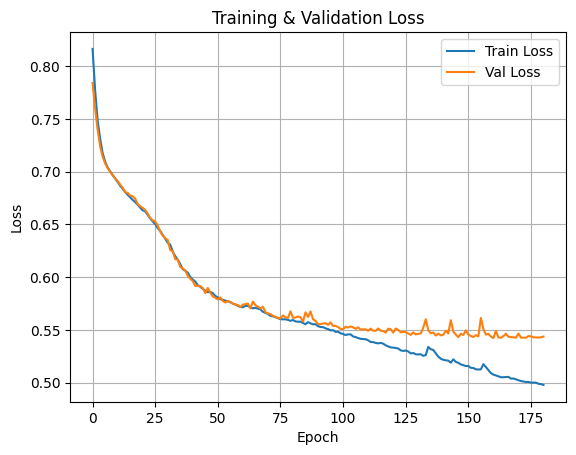

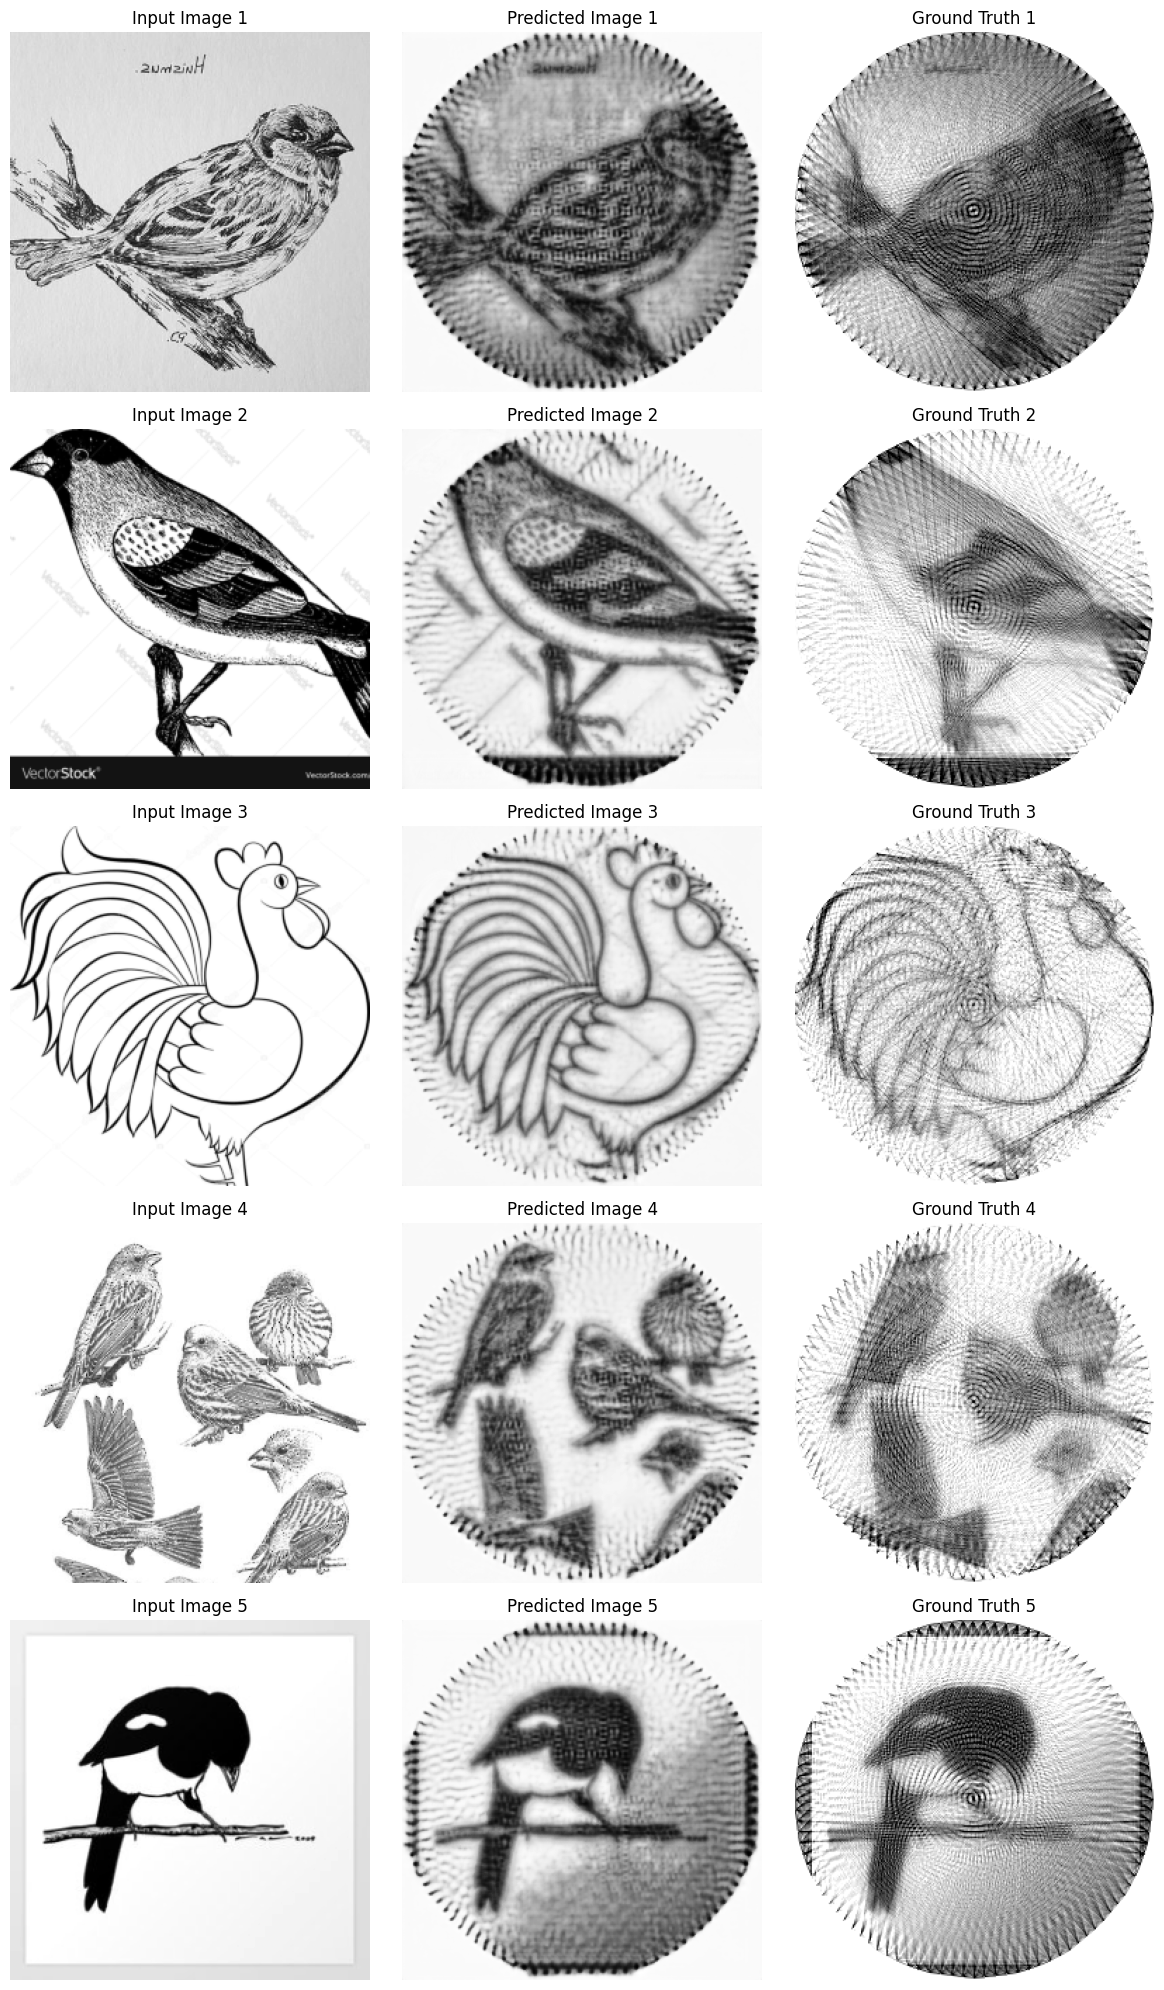

In [5]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchmetrics

class SSIMLoss(nn.Module):
    def __init__(self, data_range=1.0):
        super(SSIMLoss, self).__init__()
        self.ssim = torchmetrics.image.StructuralSimilarityIndexMeasure(data_range=data_range)

    def forward(self, x, y):
        return 1. - self.ssim(x, y)

model = UNet(1, 1)
loss_fn = SSIMLoss(data_range=1.0).cuda()

optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
early_stopping = EarlyStopping(patience=20, verbose=True)
model_checkpoint = ModelCheckpoint(save_dir='checkpoints', monitor='val_loss', mode='min', verbose=True)
optimizer.zero_grad()

train_loss_history, validation_loss_history = train(
    model,
    train_loader,
    validation_loader,
    loss_fn,
    optimizer,
    1000,
    accumulation_steps=4,
    device=torch.device("cuda"),
    scheduler=scheduler,
    early_stopping=early_stopping,
    model_checkpoint=model_checkpoint,
)

model_checkpoint.save('best_unet_checkpoint.pth')

plot_loss(train_loss_history, validation_loss_history)
plot_test_results(model, test_loader, device=torch.device("cuda"))